# analysis of altimetric data

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#from h3 import h3

#import pyinterp

import pytide

#from xhistogram.xarray import histogram

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
plt_params = {'extent':[-75,20,-70,70],
              'dticks':[20,20],
              'projection': ccrs.PlateCarree(0)}
#              'projection': ccrs.Robinson(central_longitude=-30)}
#              'projection': ccrs.Mollweide()}

In [3]:
def plot(v, vmin=None, vmax=None, x='longitude_bin', y='latitude_bin', 
         figsize=(10,10), colorbar=True, colmap=None, colorbar_kwargs={}):
    _projection = plt_params['projection']
    _extent = plt_params['extent']
    _dticks = plt_params['dticks']
    #
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection=_projection)
    ax.set_extent(_extent)
    im = v.plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                            x=x, y=y, cmap=colmap, add_colorbar=False)
    if colorbar:
        cbar = fig.colorbar(im, **colorbar_kwargs)
    else:
        cbar = None
    # grid lines:
    xticks = np.arange(_extent[0],
                       _extent[1]+_dticks[0],
                       _dticks[1]*np.sign(_extent[1]-_extent[0]))
    ax.set_xticks(xticks,crs=ccrs.PlateCarree())
    yticks = np.arange(_extent[2],
                       _extent[3]+_dticks[1],
                       _dticks[1]*np.sign(_extent[3]-_extent[2]))
    ax.set_yticks(yticks,crs=ccrs.PlateCarree())
    gl = ax.grid()
    ax.add_feature(cfeature.LAND)
    #
    #if title is not None:
    #    ax.set_title(title,fontdict={'fontsize':20, 'fontweight':'bold'})

---

## not used for now

In [4]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:60377 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


In [5]:
#from dask_kubernetes import KubeCluster
#cluster = KubeCluster()
#cluster.adapt(minimum=1, maximum=10)

In [6]:
#cluster

---

## load data

In [7]:
# if on local computer:
#ds = xr.open_zarr('/home2/pharos/othr/aponte/alti/tp')
ds = xr.open_zarr('/home/c11-data/Test_aponte/alti/tp')

In [8]:
# if on cloud:
#import gcsfs.mapping
#fs = gcsfs.GCSFileSystem(project='pangeo-cnes', token=None)
#gcsmap = gcsfs.mapping.GCSMap('pangeo-cnes/alti/tp', gcs=fs)
#ds = xr.open_zarr(gcsmap, consolidated=True)

In [9]:
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))
ds0 = ds
ds

Dataset size = 8.8 GB


<xarray.Dataset>
Dimensions:         (time: 157384325)
Coordinates:
    latitude        (time) float64 dask.array<chunksize=(1000000,), meta=np.ndarray>
    longitude       (time) float64 dask.array<chunksize=(1000000,), meta=np.ndarray>
  * time            (time) datetime64[ns] 1993-03-02T23:44:00.992296960 ... 2002-01-03T23:20:19.861993216
Data variables:
    cycle           (time) int16 dask.array<chunksize=(1000000,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(1000000,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(1000000,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(1000000,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(1000000,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(1000000,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(1000000,), meta=np.ndarray>
    track           (time) int16 dask.array<chu

In [10]:
ds.time[0]

<xarray.DataArray 'time' ()>
array('1993-03-02T23:44:00.992296960', dtype='datetime64[ns]')
Coordinates:
    latitude   float64 dask.array<chunksize=(), meta=np.ndarray>
    longitude  float64 dask.array<chunksize=(), meta=np.ndarray>
    time       datetime64[ns] 1993-03-02T23:44:00.992296960
Attributes:
    axis:           T
    long_name:      Time of measurement
    standard_name:  time

In [11]:
ds.time[-1]

<xarray.DataArray 'time' ()>
array('2002-01-03T23:20:19.861993216', dtype='datetime64[ns]')
Coordinates:
    latitude   float64 dask.array<chunksize=(), meta=np.ndarray>
    longitude  float64 dask.array<chunksize=(), meta=np.ndarray>
    time       datetime64[ns] 2002-01-03T23:20:19.861993216
Attributes:
    axis:           T
    long_name:      Time of measurement
    standard_name:  time

---

### description of each variables

<img src="capture.png">

- SSH : Sea Surface Height
- MDT : Mean Dynamic Topography (temporal mean of the SSH above the Geoid over a period N)
- MSS : Mean Sea Surface (temporal mean of the SSH over a period N)
- SLA : Sea Level Anomaly deduced from the SSH using a MMS
- dac : Dynamic Atmospheric correction
- sla_filtered : Sea level anomaly
- sla_unfiltered : Sea level anomaly


---

## with [xhistogram](https://xhistogram.readthedocs.io/en/latest/)



In [12]:
ds = ds0
ds = ds0.isel(time=slice(0,int(1e7))) # à commenter à terme
ds['longitude'] = (ds.longitude+180)%360 - 180
ds = ds.where((ds.longitude<10)&(ds.longitude>-70), drop=True)

In [19]:
lon_bins = np.arange(-70, 10, 1)
lat_bins = np.arange(-70, 70, 1)

N = (histogram(ds.longitude, ds.latitude, bins=[lon_bins, lat_bins])
     .where(N>0)
     .persist()
    )

sla_mean = (histogram(ds.longitude, ds.latitude, 
                      bins=[lon_bins, lat_bins], weights=ds.sla_filtered)/N) \
            .rename('sla_mean').persist()

sla2_mean = (histogram(ds.longitude, ds.latitude, 
                       bins=[lon_bins, lat_bins], weights=ds.sla_filtered**2)/N)\
            .rename('sla2_mean').persist()

In [20]:
sla_mean

<xarray.DataArray 'sla_mean' (longitude_bin: 79, latitude_bin: 139)>
dask.array<shape=(79, 139), dtype=float64, chunksize=(79, 139)>
Coordinates:
  * longitude_bin  (longitude_bin) float64 -69.5 -68.5 -67.5 ... 6.5 7.5 8.5
  * latitude_bin   (latitude_bin) float64 -69.5 -68.5 -67.5 ... 66.5 67.5 68.5

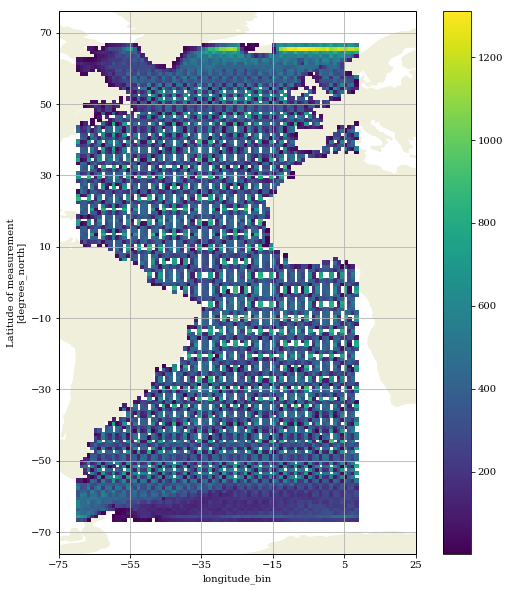

In [21]:
plot(N)

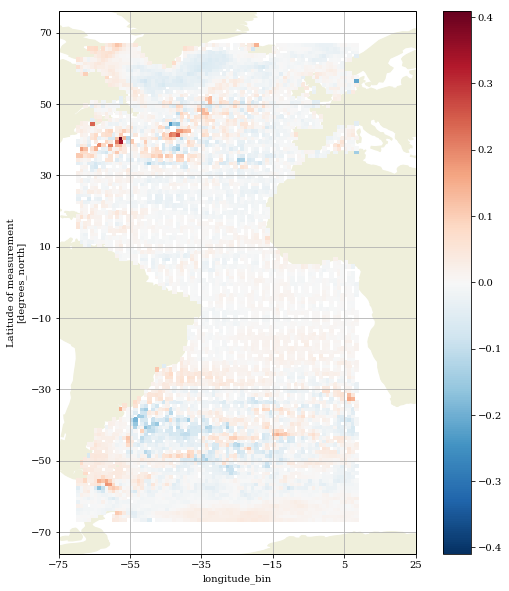

In [22]:
plot(sla_mean)

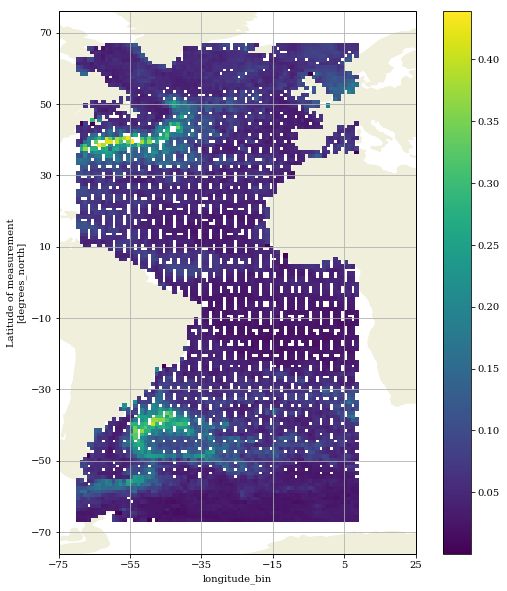

In [23]:
plot(np.sqrt(sla2_mean-sla_mean**2))

## what's next

- calculer le niveau de bruit à partir de la formule analytique et afficher

- extraire les harmoniques de marée

In [42]:
ddf = ds.isel(time=slice(0,int(1e6))).to_dask_dataframe().persist()
ddf.head()

,time,latitude,longitude,cycle,dac,lwe,mdt,ocean_tide,sla_filtered,sla_unfiltered,track
npartitions=5,,,,,,,,,,,
0,datetime64[ns],float64,float64,float64,float32,float32,float32,float64,float32,float32,float64
241656,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
975974,...,...,...,...,...,...,...,...,...,...,...
999999,...,...,...,...,...,...,...,...,...,...,...


In [43]:
# need wrapper around groupped data
lon_bins = np.arange(-70, 10, 1)
lat_bins = np.arange(-70, 70, 1)

# bin and apply tidal computation
lon_idx = pd.IntervalIndex.from_breaks(lon_bins)
lat_idx = pd.IntervalIndex.from_breaks(lat_bins)
ddf['lon_cut'] = ddf['longitude'].map_partitions(pd.cut, bins=lon_bins)
ddf['lat_cut'] = ddf['latitude'].map_partitions(pd.cut, bins=lat_bins)

In [44]:
df = ddf.groupby(['lon_cut','lat_cut']).get_group((lon_idx[35], lat_idx[100])).compute()
df.head()

In [46]:
df.head()

,time,latitude,longitude,cycle,dac,lwe,mdt,ocean_tide,sla_filtered,sla_unfiltered,track,lon_cut,lat_cut
45850,1993-07-31 22:27:06.225328128,30.575835,-34.983226,32.0,-0.1395,0.005,0.367,0.1472,0.025,0.028,113.0,"(-35, -34]","(30, 31]"
45851,1993-07-31 22:27:07.303908096,30.626716,-34.956293,32.0,-0.1398,0.005,0.366,0.1474,0.021,0.035,113.0,"(-35, -34]","(30, 31]"
45852,1993-07-31 22:27:08.382488064,30.677589,-34.929328,32.0,-0.1400,0.005,0.365,0.1474,0.016,0.045,113.0,"(-35, -34]","(30, 31]"
45853,1993-07-31 22:27:09.461068032,30.728454,-34.902330,32.0,-0.1403,0.005,0.364,0.1474,0.010,0.014,113.0,"(-35, -34]","(30, 31]"
45854,1993-07-31 22:27:10.539648000,30.779311,-34.875298,32.0,-0.1406,0.005,0.363,0.1475,0.004,-0.011,113.0,"(-35, -34]","(30, 31]"


In [26]:
ddf.head()

,time,latitude,longitude,cycle,dac,lwe,mdt,ocean_tide,sla_filtered,sla_unfiltered,track,lon_cut,lat_cut
0,1993-03-02 23:44:00.992296960,-65.755172,313.897179,17,0.2177,-0.003,-1.416,0.3507,-0.002,-0.043,57,NaN,"(-66, -65]"
1,1993-03-02 23:44:02.070876928,-65.745171,314.029894,17,0.2179,-0.003,-1.419,0.3488,0.004,-0.002,57,NaN,"(-66, -65]"
2,1993-03-02 23:44:03.149456896,-65.735048,314.162501,17,0.2181,-0.003,-1.421,0.3468,0.009,0.023,57,NaN,"(-66, -65]"
3,1993-03-02 23:44:04.228036864,-65.724803,314.295001,17,0.2183,-0.003,-1.424,0.3448,0.013,0.027,57,NaN,"(-66, -65]"
4,1993-03-02 23:44:05.306616832,-65.714435,314.427391,17,0.2184,-0.003,-1.427,0.3428,0.016,0.031,57,NaN,"(-66, -65]"


In [59]:
def harmonic_analysis(df, ssh_key, constituents=None):

    # get group id
    try:
        dr_id = df.id.unique()[0]
    except:
        dr_id = df.name    
    
    if constituents is None:
        _cst = ["M2", "K1", "O1", "P1", "Q1", "S1"]
    else:
        _cst = constituents

    time = df['time'].to_numpy(dtype="datetime64[us]")
    wt = pytide.WaveTable(_cst)
    # compute
    f, vu = wt.compute_nodal_modulations(time)

    # get harmonics
    w = wt.harmonic_analysis(df[ssh_key].to_numpy(), f, vu)

    # predicted tidal contribution
    #hp = wt.tide_from_tide_series(time, w)
    
    out = pd.DataFrame(w, columns = _cst, index=dr_id)
    return out
    
out = harmonic_analysis(df, ssh_key='sla_unfiltered')
out

AttributeError: 'DataFrame' object has no attribute 'name'

---
## with [pyinterp](https://pangeo-pyinterp.readthedocs.io/en/latest/examples.html)

In [9]:
ds = ds0.isel(time=slice(0,int(1e8))).chunk({'time':1e6})
#ds = ds0.where((ds.longitude<45)&(ds.longitude>-45), drop=True)
#ds = ds0 # crashes
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))

Dataset size = 5.6 GB


In [10]:
ds = ds.persist()

In [15]:
binning = pyinterp.Binning2D(
    pyinterp.Axis(np.arange(-180, 180, 1), is_circle=True),
    pyinterp.Axis(np.arange(-90, 95, 1)))

In [ ]:
#mx, my = np.meshgrid(ds.longitude, ds.latitude)
binning.push(ds.longitude, ds.latitude, ds.mdt, simple=True)

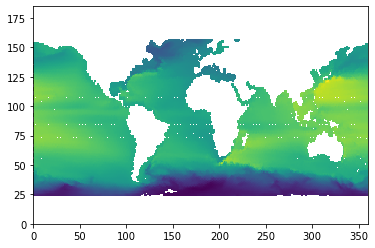

In [13]:
plt.pcolormesh(binning.variable('mean').T)

In [ ]:
binning.variable('mean')

In [1]:
np.asarray(ds.mdt).flatten().shape

NameError: name 'np' is not defined

---
## with [h3](https://github.com/uber/h3-py)

Python bindings for H3, a hierarchical hexagonal geospatial indexing system (see [here](https://uber.github.io/h3/))

| H3 Resolution | Average Hexagon Area (km2) | Average Hexagon Edge Length (km) | Number of unique indexes |
| ------------- |:--------------------------:|:-------------------------------- |:------------------------:|
| 0 | 4,250,546.8477000 | 1,107.712591000 | 122 |
| 1 | 607,220.9782429 | 418.676005500 | 842 | 
| 2 | 86,745.8540347 | 158.244655800 | 5,882 | 
| 3 | 12,392.2648621 | 59.810857940 | 41,162 | 
| 4 | 1,770.3235517 | 22.606379400 | 288,122 | 
| 5 | 252.9033645 | 8.544408276 | 2,016,842 | 
| 6 | 36.1290521 | 3.229482772 | 14,117,882 | 
| 7 | 5.1612932 | 1.220629759 | 98,825,162 | 
| 8 | 0.7373276 | 0.461354684 | 691,776,122 |

In [13]:
#import h3
from h3 import h3

In [14]:
ddf = ds.isel(time=slice(0,int(1e6))).to_dask_dataframe().persist()
ddf.head()

,time,latitude,longitude,cycle,dac,lwe,mdt,ocean_tide,sla_filtered,sla_unfiltered,track
0,1993-03-02 23:44:00.992296960,-65.755172,-46.102821,17.0,0.2177,-0.003,-1.416,0.3507,-0.002,-0.043,57.0
1,1993-03-02 23:44:02.070876928,-65.745171,-45.970106,17.0,0.2179,-0.003,-1.419,0.3488,0.004,-0.002,57.0
2,1993-03-02 23:44:03.149456896,-65.735048,-45.837499,17.0,0.2181,-0.003,-1.421,0.3468,0.009,0.023,57.0
3,1993-03-02 23:44:04.228036864,-65.724803,-45.704999,17.0,0.2183,-0.003,-1.424,0.3448,0.013,0.027,57.0
4,1993-03-02 23:44:05.306616832,-65.714435,-45.572609,17.0,0.2184,-0.003,-1.427,0.3428,0.016,0.031,57.0


In [16]:
resolution = 5

def get_hex(row, resolution):
    return h3.geo_to_h3(row["latitude"], row["longitude"], resolution)

ddf['hex_id'] = ddf.apply(get_hex, axis=1, args=(resolution,), meta='string')
ddf.head()

,time,latitude,longitude,cycle,dac,lwe,mdt,ocean_tide,sla_filtered,sla_unfiltered,track,hex_id
0,1993-03-02 23:44:00.992296960,-65.755172,-46.102821,17.0,0.2177,-0.003,-1.416,0.3507,-0.002,-0.043,57.0,85ee5b93fffffff
1,1993-03-02 23:44:02.070876928,-65.745171,-45.970106,17.0,0.2179,-0.003,-1.419,0.3488,0.004,-0.002,57.0,85ee5b83fffffff
2,1993-03-02 23:44:03.149456896,-65.735048,-45.837499,17.0,0.2181,-0.003,-1.421,0.3468,0.009,0.023,57.0,85ee5b83fffffff
3,1993-03-02 23:44:04.228036864,-65.724803,-45.704999,17.0,0.2183,-0.003,-1.424,0.3448,0.013,0.027,57.0,85ee5b8bfffffff
4,1993-03-02 23:44:05.306616832,-65.714435,-45.572609,17.0,0.2184,-0.003,-1.427,0.3428,0.016,0.031,57.0,85ee5b8bfffffff


In [47]:
df_stats = (ddf.drop(columns=['time'])[['sla_unfiltered','hex_id']]
            .groupby('hex_id')
            .aggregate(['count', 'mean', 'std', 'max', 'min'])
           ).compute()

In [48]:
df_stats.head()

sla_unfiltered                                 
                         count     mean       std    max    min
hex_id                                                         
85060903fffffff              3  0.07400  0.047466  0.115  0.022
85060907fffffff              2  0.06650  0.010607  0.074  0.059
8506090bfffffff              4  0.00975  0.115477  0.114 -0.122
8506090ffffffff              4  0.02825  0.044932  0.084 -0.016
85060913fffffff              7  0.06200  0.039205  0.100  0.015

In [49]:
df_stats = df_stats.reset_index() #.drop(columns=['longitude','latitude'])
df_stats['lat'] = df_stats['hex_id'].apply(lambda x: h3.h3_to_geo(x)[0])
df_stats['lon'] = df_stats['hex_id'].apply(lambda x: h3.h3_to_geo(x)[1])

In [50]:
df_stats

hex_id sla_unfiltered                                    \
                                count      mean       std    max    min   
0      85060903fffffff              3  0.074000  0.047466  0.115  0.022   
1      85060907fffffff              2  0.066500  0.010607  0.074  0.059   
2      8506090bfffffff              4  0.009750  0.115477  0.114 -0.122   
3      8506090ffffffff              4  0.028250  0.044932  0.084 -0.016   
4      85060913fffffff              7  0.062000  0.039205  0.100  0.015   
...                ...            ...       ...       ...    ...    ...   
53120  85eeebc7fffffff             18  0.026833  0.023015  0.071 -0.017   
53121  85eeebcbfffffff             14  0.021357  0.034346  0.075 -0.039   
53122  85eeebcffffffff             17  0.016412  0.027129  0.057 -0.054   
53123  85eeebd7fffffff             19  0.011579  0.032274  0.052 -0.050   
53124  85eeebdbfffffff              5  0.059600  0.025215  0.091  0.027   

             lat        lon  
                             
0      65.905912 -34.371550  
1      65.747368 -34.400027  
2      65.994495 -34.675244  
3      65.835769 -34.701967  
4      65.975229 -34.039865  
...          ...        ...  
53120 -65.965741 -37.678722  
53121 -66.031557 -36.988204  
53122 -65.918904 -37.286444  
53123 -66.125804 -37.776885  
53124 -66.192117 -37.081973  

[53125 rows x 8 columns]

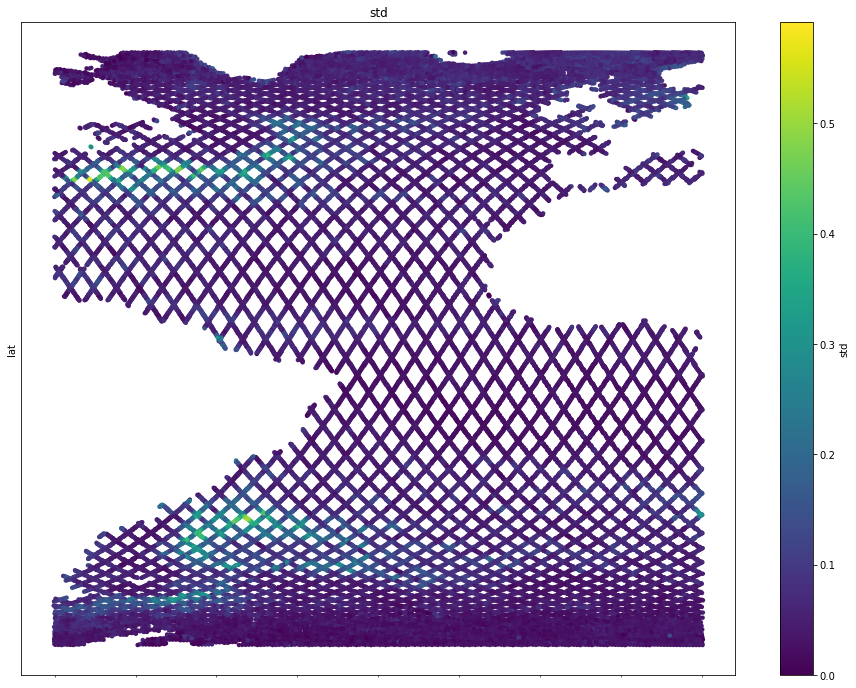

In [51]:
def plot_scatter(df, metric_col, x='lon', y='lat', marker='o', alpha=1, 
                 figsize=(16,12), colormap='viridis'):
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, 
                    marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])
    
#plot_scatter(df_stats['sla_unfiltered'], 'mean')
plot_scatter(df_stats['sla_unfiltered'].join([df_stats['lon'], df_stats['lat']]), 'std')

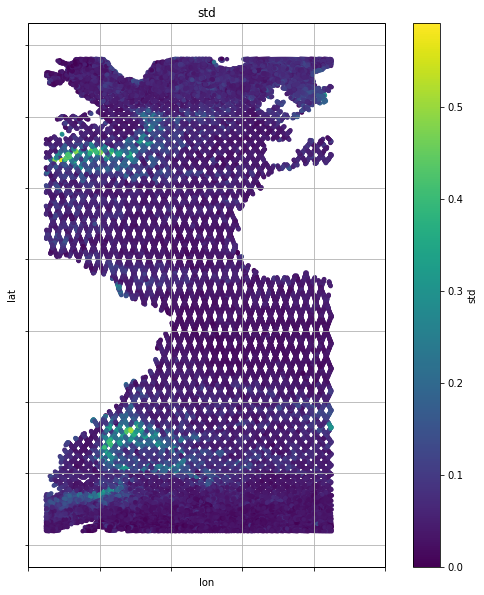

In [58]:
def plot_scatter_geo(df, metric_col, vmin=None, vmax=None, 
             x='lon', y='lat', marker='o', alpha=1, 
             figsize=(10,10), colorbar=True, colormap='viridis', colorbar_kwargs={}):
    #
    _projection = plt_params['projection']
    _extent = plt_params['extent']
    _dticks = plt_params['dticks']
    #
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection=_projection)
    ax.set_extent(_extent)
    #im = v.plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
    #                        x=x, y=y, cmap=colmap, add_colorbar=False)
    im = df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col,
                    vmin=vmin, vmax=vmax,
                    ax = ax,
                    edgecolors='none', colormap=colormap, 
                    marker=marker, alpha=alpha, figsize=figsize,
                    transform=ccrs.PlateCarree())
    plt.xticks([], []); plt.yticks([], [])
    
    #if colorbar:
    #    cbar = fig.colorbar(im, **colorbar_kwargs)
    #else:
    #    cbar = None
    # grid lines:
    xticks = np.arange(_extent[0],
                       _extent[1]+_dticks[0],
                       _dticks[1]*np.sign(_extent[1]-_extent[0]))
    ax.set_xticks(xticks,crs=ccrs.PlateCarree())
    yticks = np.arange(_extent[2],
                       _extent[3]+_dticks[1],
                       _dticks[1]*np.sign(_extent[3]-_extent[2]))
    ax.set_yticks(yticks,crs=ccrs.PlateCarree())
    gl = ax.grid()
    #ax.add_feature(cfeature.LAND)
    #
    #if title is not None:
    #    ax.set_title(title,fontdict={'fontsize':20, 'fontweight':'bold'})
    
plot_scatter_geo(df_stats['sla_unfiltered'].join([df_stats['lon'], df_stats['lat']]), 'std')